In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn import manifold
import argparse
import os
import numpy as np

In [3]:
parser = argparse.ArgumentParser(description='Build t-SNE from fingerprints.')
parser.add_argument('-i', '--input', type=str, default='output/fingerprints.npy')
parser.add_argument('-o', '--output', type=str, default='output')
parser.add_argument('-p', '--perplexity', type=int, default=30)
parser.add_argument('-l', '--learning_rate', type=float, default=100)
args, _ = parser.parse_known_args()

In [4]:
fingerprints = np.load(args.input)

In [5]:
tsne = manifold.TSNE(n_components=2, perplexity=args.perplexity, learning_rate=args.learning_rate, verbose=2)
%time tsne2d = tsne.fit_transform(fingerprints)
tsne2d -= tsne2d.min()
tsne2d /= tsne2d.max()
np.savetxt(os.path.join(args.output, 'tsne2d.tsv'), tsne2d, fmt='%.5f', delimiter='\t')

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1090
[t-SNE] Computed conditional probabilities for sample 1090 / 1090
[t-SNE] Mean sigma: 0.045483
[t-SNE] Iteration 25: error = 2.2408915, gradient norm = 0.0020995
[t-SNE] Iteration 50: error = 2.2082715, gradient norm = 0.0203290
[t-SNE] Iteration 75: error = 1.4035937, gradient norm = 0.0092047
[t-SNE] Iteration 100: error = 1.2999504, gradient norm = 0.0075876
[t-SNE] Error after 100 iterations with early exaggeration: 1.299950
[t-SNE] Iteration 125: error = 1.1576678, gradient norm = 0.0056647
[t-SNE] Iteration 150: error = 1.1178558, gradient norm = 0.0052324
[t-SNE] Iteration 175: error = 1.1081685, gradient norm = 0.0051469
[t-SNE] Iteration 200: error = 1.1055621, gradient norm = 0.0051254
[t-SNE] Iteration 225: error = 1.1048349, gradient norm = 0.0051180
[t-SNE] Iteration 250: error = 1.1046323, gradient norm = 0.0051159
[t-SNE] Ite

In [6]:
tsne = manifold.TSNE(n_components=3, perplexity=args.perplexity, learning_rate=args.learning_rate, verbose=2)
%time tsne3d = tsne.fit_transform(fingerprints)
tsne3d -= tsne3d.min()
tsne3d /= tsne3d.max()
np.savetxt(os.path.join(args.output, 'tsne3d.tsv'), tsne3d, fmt='%.5f', delimiter='\t')

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1090
[t-SNE] Computed conditional probabilities for sample 1090 / 1090
[t-SNE] Mean sigma: 0.045483
[t-SNE] Iteration 25: error = 2.3280840, gradient norm = 0.0346667
[t-SNE] Iteration 50: error = 2.0321586, gradient norm = 0.0194308
[t-SNE] Iteration 75: error = 1.3579239, gradient norm = 0.0056973
[t-SNE] Iteration 100: error = 1.2735044, gradient norm = 0.0048372
[t-SNE] Error after 100 iterations with early exaggeration: 1.273504
[t-SNE] Iteration 125: error = 1.1432949, gradient norm = 0.0037675
[t-SNE] Iteration 150: error = 1.1052227, gradient norm = 0.0034927
[t-SNE] Iteration 175: error = 1.0960301, gradient norm = 0.0034361
[t-SNE] Iteration 200: error = 1.0935571, gradient norm = 0.0034210
[t-SNE] Iteration 225: error = 1.0928767, gradient norm = 0.0034176
[t-SNE] Iteration 250: error = 1.0926840, gradient norm = 0.0034169
[t-SNE] Ite

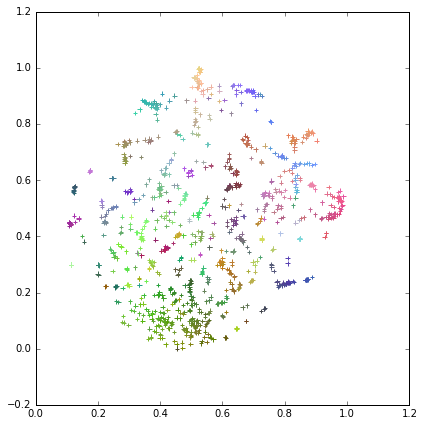

In [8]:
plt.figure(figsize=(6,6))
points = tsne2d
colors = tsne3d
plt.scatter(points[:,0], points[:,1], marker='+', c=colors)
plt.tight_layout()
plt.show()